# Gaussian priors in infinite dimensions

In this notebook we show how to construct PDE-based priors that lead to well-posed Bayesian inverse problems in infinite dimesions.
Specifically, we will consider a Gaussian prior $\mu_{\rm prior} \sim \mathcal{N}( m_{\rm prior}, \mathcal{C}_{\rm prior} )$, where
the covariance operator $\mathcal{C}_{\rm prior}$ is defined as the inverse of an elliptic differential operator, i.e.

$$ \mathcal{C}_{\rm prior} = \left( \delta I - \gamma \Delta \right)^{-\alpha}, $$

equipped with homogeneous Neumann, Dirichlet or Robin boundary conditions, and $m_{\rm prior} \in H^{\frac{\alpha}{2}}(\Omega)$, where $\Omega \subset \mathbb{R}^d$.

The parameter $\alpha > \frac{d}{2}$ controls the smoothness of the random field and ensures that $\mathcal{C}_{\rm prior}$ is a trace class operator (i.e., the infinite sum of the eigenvalues of  $\mathcal{C}_{\rm prior}$ is finite). 
The fact that $\mathcal{C}_{\rm prior}$ is trace class is extremely important as it guaratees that the pointwise variance of the samples is finite. (Recall that for a Gaussian random field 
$ E [\int_{\Omega}(m - m_{\rm prior})^2\,dx = \operatorname{trace}(\mathcal{C}_{\rm prior})]$).

The parameters $\delta>0$, $\gamma>0$ can be constant in $\Omega$ (in this case the prior is called stationary) or spatially varing.

It can be shown that, in the case of the BiLaplacian prior ($\alpha=2$) in $d$-spatial dimensions, the relationship between the PDE coefficients $\gamma$ and $\delta$ and the desired marginal variance $\sigma^2$ and correlation length $\rho$ is

$$ \gamma = \frac{1}{s}, \quad \delta = \frac{\kappa^2}{s}, $$
where
$$ \nu = 2. - \frac{d}{2}, \quad \kappa = \frac{\sqrt{8\nu}}{\rho}, \text{ and } s = \sigma\kappa^\nu\sqrt{\frac{(4\pi)^{d/2}}{\Gamma(\nu)}}.$$


The above formulae are implemented in the `hIPPYlib` function `BiLaplacianComputeCoefficients`, which calculates the coefficients `gamma` and `delta` of the BiLaplacian prior ($\alpha=2$) given the desired marginal variance $\sigma^2$ and correlation length $\rho$.

## Import dependencies

In [1]:
import dolfin as dl
import numpy as np
import math

import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )

from hippylib import *

import matplotlib.pyplot as plt
%matplotlib inline

## Plot the marginal variance and correlation structure at at given point

In [2]:
def correlationStructure(prior, center):
    rhs = dl.Vector()
    prior.init_vector(rhs, 0)
    
    corrStruct = dl.Vector()
    prior.init_vector(corrStruct, 0)
    
    ps = dl.PointSource(prior.Vh, center, 1.)
    ps.apply(rhs)
    
    prior.Rsolver.solve(corrStruct, rhs)
    
    return vector2Function(corrStruct, prior.Vh)

def showMarginalVariance_Correlation(mesh, sigma2, rho, pt):
    """
    Show the plot of the marginal variance and correlation structure
    - mesh: The finite element mesh
    - sigma2: The prescribed marginal variance
    - rho: The prescriced coerrelation lenghth
    - pt: Point at which to show the correlation structure
    """
    ndim = mesh.geometric_dimension()
    Vh = dl.FunctionSpace(mesh, "CG", 1)

    gamma, delta = BiLaplacianComputeCoefficients(sigma2, rho, ndim)

    prior = BiLaplacianPrior(Vh, gamma, delta,  robin_bc=True)
    prior.Asolver = dl.PETScLUSolver(dl.as_backend_type(prior.A)) #Replace iterative with direct solver


    ## pointwise variance
    r = int(4*np.sqrt(Vh.dim()))
    pointwise_variance = vector2Function(prior.pointwise_variance(method="Randomized", r=r), Vh)

    correlation_struc  = correlationStructure(prior, dl.Point(.5,.5))

    print("Prescribed marginal variance: ", sigma2)
    print("Actual marginal variance:", correlation_struc.vector().norm("linf"))

    plt.subplot(121)
    dl.plot(pointwise_variance)
    plt.title("Marginal variance")
    
    plt.subplot(122)
    dl.plot(correlation_struc)
    plt.title("Correlation")
    
    plt.show()

## The 1D case

Prescribed marginal variance:  4
Actual marginal variance: 4.003204476208129


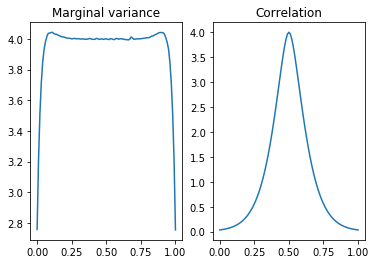

In [3]:
mesh = dl.UnitIntervalMesh(100)
sigma2 = 4
rho    = 0.25
pt = dl.Point(.5)

showMarginalVariance_Correlation(mesh, sigma2, rho, pt)

# The 2D case

Prescribed marginal variance:  4
Actual marginal variance: 3.9842201152094603


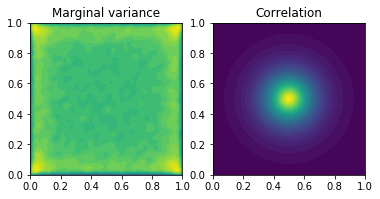

In [5]:
mesh = dl.UnitSquareMesh(64,64)
sigma2 = 4
rho    = 0.25
pt = dl.Point(.5, .5)

showMarginalVariance_Correlation(mesh, sigma2, rho, pt)

Copyright &copy; 2016-2018, The University of Texas at Austin & University of California, Merced.<br>
Copyright (c) 2019-2022, The University of Texas at Austin, University of California--Merced, Washington University in St. Louis.<br>
All Rights reserved.<br>
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.